# Image segmentation

In dit voorbeeld zullen we gebruik maken van de Oxford Pets Dataset. Het model zal leren om objecten (bijv. huisdieren) van de achtergrond te onderscheiden.
We gebruiken hiervoor de U-Net architectuur, een populair model voor afbeeldingssegmentatie. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import opendatasets as od
import tarfile

# Controleren of GPU beschikbaar is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
od.download("http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz", data_dir="oxford")
od.download("http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz", data_dir="oxford")

# Open het .tar.gz bestand
with tarfile.open("oxford/images.tar.gz", "r:gz") as tar:
    # Pak alle inhoud uit naar de "oxford/images" directory
#    tar.extractall(path="oxford")

# Open het .tar.gz bestand
with tarfile.open("oxford/annotations.tar.gz", "r:gz") as tar:
    # Pak alle inhoud uit naar de "oxford/images" directory
#    tar.extractall(path="oxford")

Using downloaded and verified file: oxford/images.tar.gz
Using downloaded and verified file: oxford/annotations.tar.gz


## Dataset inladen

In [19]:
# Transformeer de afbeeldingen en maskers
transform = transforms.Compose([
    transforms.Resize((572, 572)),
    transforms.ToTensor(),
])

class OxfordPetsDataset(data.Dataset):
    def __init__(self, root, transform=None, output_size=388):
        self.root = root
        self.transform = transform
        self.output_size=output_size
        self.image_files = sorted([f for f in os.listdir(os.path.join(root, 'images')) if f.endswith('.jpg')])
        self.mask_files = sorted([f for f in os.listdir(os.path.join(root, 'annotations/trimaps')) if f.endswith('.png') and not f.startswith(".")])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'images', self.image_files[idx])
        mask_path = os.path.join(self.root, 'annotations/trimaps', self.mask_files[idx])
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)
        
        if self.transform:
            image = self.transform(image)
        
        mask = transforms.PILToTensor()(mask)
        mask = transforms.Resize((self.output_size, self.output_size))(mask)
          
        # Segmentatiemaskers zijn geannoteerd met waarden 1, 2, 3
        mask = mask.squeeze(0)  # Verwijder kanaal 0, aangezien het grijswaarden zijn
        mask = torch.where(mask >= 2.0, torch.ones_like(mask, dtype=torch.float), torch.zeros_like(mask, dtype=torch.float))  # Mwaarde 2 omzetten naar 1, andere 0)
        
        return image, mask

# Pad naar de dataset
root = './oxford'

# Laad de dataset
train_dataset = OxfordPetsDataset(root=root, transform=transform)
train_loader = data.DataLoader(train_dataset, batch_size=8, shuffle=True)

for images, mask in train_loader:
    print(images.shape)
    print(mask.shape)
    print(mask.max())
    break

torch.Size([8, 3, 572, 572])
torch.Size([8, 388, 388])
tensor(1.)


## Samenstellen van het U-net model

In [3]:
class UNet(nn.Module):

    def __init__(self):
        super(UNet, self).__init__() # constructor base-class

        # encoder
        self.enc_block1 = self.conv_block(3, 64)
        self.enc_block2 = self.conv_block(64, 128)
        self.enc_block3 = self.conv_block(128, 256)
        self.enc_block4 = self.conv_block(256, 512)

        # bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # decoder
        self.dec_block1 = self.conv_block(1024 + 512, 512) # bottleneck + enc_block4
        self.dec_block2 = self.conv_block(512+256, 256) # dec_block1 + enc_block3
        self.dec_block3 = self.conv_block(256+128, 128)
        self.dec_block4 = self.conv_block(128+64, 64)

        # de 1 hier bepaalt hoeveel klassen we toelaten. In dit geval 1 want binaire classificatie (huisdier of niet)
        # als er meer opties zijn: is het 1 per klasse (en eventueel 1 extra voor background)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)

        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        # encoder
        enc_block1 = self.enc_block1(x)
        #print(enc_block1.shape)
        enc_block2 = self.enc_block2(self.maxpool(enc_block1))
        #print(enc_block2.shape)
        enc_block3 = self.enc_block3(self.maxpool(enc_block2))
        #print(enc_block3.shape)
        enc_block4 = self.enc_block4(self.maxpool(enc_block3))
        #print(enc_block4.shape)

        # bottleneck
        bottleneck = self.bottleneck(self.maxpool(enc_block4))

        # decoder
        dec_block1 = self.upsample_and_concat(bottleneck, enc_block4) # voeg bottleneck en enc_block4
        dec_block1 = self.dec_block1(dec_block1)
        
        dec_block2 = self.upsample_and_concat(dec_block1, enc_block3) # voeg bottleneck en enc_block4
        dec_block2 = self.dec_block2(dec_block2)
        
        dec_block3 = self.upsample_and_concat(dec_block2, enc_block2) # voeg bottleneck en enc_block4
        dec_block3 = self.dec_block3(dec_block3)
        
        dec_block4 = self.upsample_and_concat(dec_block3, enc_block1) # voeg bottleneck en enc_block4
        dec_block4 = self.dec_block4(dec_block4)

        output = torch.sigmoid(self.final_conv(dec_block4)) # sigmoid want binary classification
        return output

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, stride=1, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, stride=1, kernel_size=3, padding=0),
            nn.ReLU()
        )

    def upsample_and_concat(self, x1, x2):
        x1 = nn.functional.interpolate(x1, scale_factor=2, mode='bilinear')
        x2 = torchvision.transforms.functional.resize(x2, x1.shape[2])
        return torch.cat([x1, x2], dim=1)

model = UNet().to(device)

In [18]:
for images, mask in train_loader:
    outputs = decoder(encoder(images))
    print(outputs.shape)
    break

torch.Size([8, 1, 128, 128])


## Training loop

In [6]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs=2
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for idx, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device) # stuur het naar de gpu als je er 1 hebt
        
        #optimizer.zero_grad()
        model.zero_grad(set_to_none=True)
        outputs = model(images)
        #print(outputs.shape)
        #print(outputs.max())
        #break
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        if idx%100==99:
            print(f"Busy with batch {idx}/{len(train_loader)}")

        running_loss += loss.item()
        
    print(f"Epoch {epoch}: running loss is {running_loss / len(train_loader)}")

KeyboardInterrupt: 

## Evaluatie

In [ ]:
# Evalueren en Visualiseren
model.eval()

def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].cpu().numpy().squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

# Testen op enkele voorbeelden
with torch.no_grad():
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        predictions = model(images)
        print(masks[0].unique())
        predictions = (predictions > 0.5).float()  # Thresholding
        display([images[0].permute(1, 2, 0), masks[0], predictions[0]])
        break


# Kleiner model om te testen

In [31]:
# kleiner model om te testen
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = OxfordPetsDataset(root=root, transform=transform, output_size=128)
train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)

encoder = nn.Sequential(
    nn.Conv2d(3, 16, stride=1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, stride=1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, stride=1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, stride=1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2)
)

decoder=nn.Sequential(
    nn.ConvTranspose2d(128, 64, stride=1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='bilinear'),
    nn.ConvTranspose2d(64, 32, stride=1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='bilinear'),
    nn.ConvTranspose2d(32, 16, stride=1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='bilinear'),
    nn.ConvTranspose2d(16, 1, stride=1, kernel_size=3, padding=1),
    nn.Sigmoid(),
    nn.Upsample(scale_factor=2, mode='nearest')
)

small_model = nn.Sequential(encoder,decoder)

In [32]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs=2
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for idx, (images, masks) in enumerate(train_loader):
        #optimizer.zero_grad()
        small_model.zero_grad(set_to_none=True)
        outputs = small_model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        if idx%100==99:
            print(f"Busy with batch {idx}/{len(train_loader)}")

        running_loss += loss.item()
        
    print(f"Epoch {epoch}: running loss is {running_loss / len(train_loader)}")

Busy with batch 99/231
Busy with batch 199/231
Epoch 0: running loss is 0.6441156188130894
Busy with batch 99/231
Busy with batch 199/231
Epoch 1: running loss is 0.6441199449233679
Busy with batch 99/231
Busy with batch 199/231
Epoch 2: running loss is 0.6441175488682537
Busy with batch 99/231
Busy with batch 199/231
Epoch 3: running loss is 0.6441203593175648
Busy with batch 99/231
Busy with batch 199/231
Epoch 4: running loss is 0.6441198538392137
Busy with batch 99/231
Busy with batch 199/231
Epoch 5: running loss is 0.6441164037365934
Busy with batch 99/231
Busy with batch 199/231
Epoch 6: running loss is 0.6441205995423454
Busy with batch 99/231
Busy with batch 199/231
Epoch 7: running loss is 0.6441182896688387
Busy with batch 99/231
Busy with batch 199/231
Epoch 8: running loss is 0.6441168694785147
Busy with batch 99/231
Busy with batch 199/231
Epoch 9: running loss is 0.644117863921376


tensor([0., 1.])


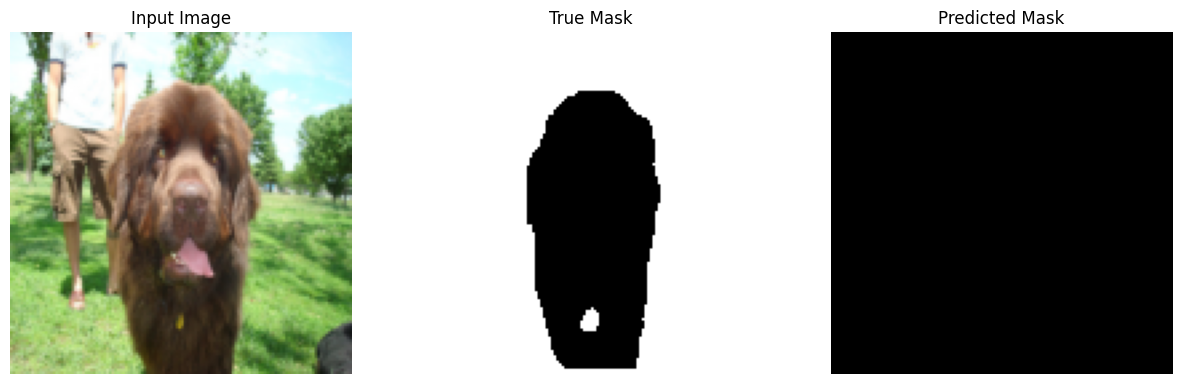

In [33]:
model.eval()

def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].cpu().numpy().squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

# Testen op enkele voorbeelden
with torch.no_grad():
    for images, masks in train_loader:
        predictions = small_model(images)
        print(masks[0].unique())
        predictions = (predictions > 0.5).float()*255  # Thresholding
        display([images[0].permute(1, 2, 0), masks[0], predictions[0]])
        break

## Oefening

Herbouw het bovenstaande model met Keras, zorg er ook voor dat de loss bestudeerd kan worden met tensorboard

In [ ]:
import keras
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
from keras.utils import Sequence, to_categorical
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

os.environ["KERAS_BACKEND"] = "torch"